# Decoding Encrypted Messages using Recurrent Neural Networks (RNNs)

In this notebook we demonstrate an approach to decode encrypted messages using a Recurrent Neural Network (RNN). Specifically, we'll explore how RNNs can be trained to learn the underlying patterns in encrypted text and decode messages without prior knowledge of the encryption being in place. Three different RNN models will be trained and compared: Simple RNN, GRU and LSTM.

## Motivation:
In cryptography, decoding encrypted messages traditionally involves techniques such as genetic algorithms or brute force methods. This notebook aims to showcase the capabilities of RNNs in decoding encrypted messages (provided sufficient training data is available). 

## Contents:
1. [Importing necessary libraries.](#libraries)
2. [Preprocessing the data](#preprocessing): Tokenizing characters, encoding text, and preparing training data.
3. [Building the RNN models](#buildingmodel): Designing the architecture of the different RNN models for sequence-to-sequence learning.
4. [Training the RNN models](#trainmodel): Compiling and fitting the models on the training data.
5. [Evaluating the models](#evaluatemodel): Assessing the performance of the trained models on test data.
6. [Decoding encrypted messages](#decode): Using the trained models to decode new encrypted messages.


### [Importing necessary libraries.](#libraries)

In [1]:
import string
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### [Preprocessing the data](#preprocessing)

In [2]:
# Set the original and encrypted alphabets

original = list(string.ascii_lowercase)
encryption = list(string.ascii_lowercase) #alphabet to be encrypted

random.seed(10) # for reproducibility of results
random.shuffle(encryption)

In [3]:
# Create dictionaries for encoding and decoding characters

encode_dict = {k:v for k,v in zip(original, encryption)}
encode_dict[" "] = " " #Blank characters will not be encrypted

decode_dict = {v:k for k,v in encode_dict.items()}
decode_dict[" "] = " " #Blank characters will not be encrypted

In [4]:
# Tokenize characters

tokenizer = Tokenizer(char_level=True) #must be initiated at character level rather than at word level
tokenizer.fit_on_texts(" " + string.ascii_lowercase) # no need to provide a whole text, just the characters we want it to keep track of.

In [5]:
# Tokenized characters with their indices
tokenizer.word_index

{' ': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27}

In [6]:
# Function to encode a line of text

def encode_line(line):
    encoded_line = ""
    for char in line:
        if char in encode_dict: # only take into account characters considered in our alphabet
            encoded_line += encode_dict[char]
    return encoded_line

In [7]:
# Generate train and test data

y = [] # to store decoded (tokenized) sequences
X = [] # to store encoded (tokenized) sequences

n_samples = 3000 # how many pairs of encoded-decoded sequences we want?

with open("moby_dick.txt", "r",encoding="utf-8") as file: # you can actually fit in any .txt document you like
        samples=0
        for line in file:
            line = line.rstrip()
            if line: #checks that it is not blank
                line = line.lower()
                line_int = []
                for char in line:
                    if char in tokenizer.word_index: # only take into account characters considered in our alphabet. Punctuation, numbers... are excluded
                        line_int.append(tokenizer.word_index[char])
                y.append(line_int)

                encoded_line = encode_line(line) #encodes the text line under consideration
                encode_line_int=[]
                for char in encoded_line:
                    if char in tokenizer.word_index:
                        encode_line_int.append(tokenizer.word_index[char])
                X.append(encode_line_int)

                samples+=1
                
            if samples == n_samples:
                break

In [8]:
# Determine the maximum sequence length to later adjust the padding for the RNN's input

L = max([len(seq) for seq in y])

In [9]:
# Function to pad sequences to a desired length

def pad_sequences(sequences, desired_len):
    padded_sequences = []
    for sequence in sequences:
        n_zeros = desired_len - len(sequence)
        pad = np.zeros(shape=n_zeros, dtype=np.uint32).tolist()
        padded_sequence = pad+sequence
        padded_sequences.append(padded_sequence)
    return padded_sequences
        

In [10]:
# Pad all the sequences

X_padded = np.array(pad_sequences(X, L))
y_padded = np.array(pad_sequences(y,L))

In [11]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_padded,y_padded,test_size = 0.33) # 33% of data will be used as validation

### [Building the RNNs models (LSTM, GRU, SimpleRNN)](#buildingmodel)

In [12]:
# Define vocabulary size

V = len(tokenizer.word_index) + 1 # Adding +1 because 0 now appears as an index in the sequences due to padding

In [13]:
RNN_layer = {"GRU":GRU, "LSTM":LSTM, "SimpleRNN": SimpleRNN}
models = []

for layer_name, layer in RNN_layer.items():
    # Input layer
    i = Input(shape=(L, 1))  # L timesteps x 1 feature each. Recall that L is the sequence lenght.
    
    # Corresponding RNN layer
    x = layer(32, return_sequences=True)(i)  # returns the whole sequence # Here we could have masked the zeros resulting from the padding process
    
    # Dense layer
    x = Dense(units=V, activation='softmax')(x)
    
    # Assembling Model
    model = Model(i, x, name=layer_name + "_Model")
    models.append(model)
    

In [14]:
for model in models:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
for model in models:
    model.summary()
    print("\n")

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 71, 1)]           0         
                                                                 
 gru (GRU)                   (None, 71, 32)            3360      
                                                                 
 dense (Dense)               (None, 71, 28)            924       
                                                                 
Total params: 4284 (16.73 KB)
Trainable params: 4284 (16.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 71, 1)]           0         
                                                                 
 

### [Training the RNN models](#trainmodel)

In [16]:
# Reshape X_train to match the input shape of the model
X_train_reshaped = X_train.reshape(-1, 71, 1)

models_history = {}

for model in models:

    print(f"\n Model: {model.name}\n")

    # Train the model
    history = model.fit(
        X_train_reshaped,  # Reshaped input data
        y_train,
        epochs=60,
        validation_data=(X_test.reshape(-1, 71, 1), y_test) # We use X_test and y_test for validation
    )

    models_history[model.name] = history


 Model: GRU_Model

Epoch 1/60


63/63 [==============================] - 4s 27ms/step - loss: 2.9777 - accuracy: 0.3127 - val_loss: 2.5546 - val_accuracy: 0.3669
Epoch 2/60
63/63 [==============================] - 1s 20ms/step - loss: 2.2209 - accuracy: 0.4523 - val_loss: 1.9427 - val_accuracy: 0.4761
Epoch 3/60
63/63 [==============================] - 1s 20ms/step - loss: 1.7967 - accuracy: 0.5132 - val_loss: 1.7067 - val_accuracy: 0.5301
Epoch 4/60
63/63 [==============================] - 1s 20ms/step - loss: 1.5973 - accuracy: 0.5678 - val_loss: 1.5332 - val_accuracy: 0.5709
Epoch 5/60
63/63 [==============================] - 1s 19ms/step - loss: 1.4424 - accuracy: 0.5792 - val_loss: 1.3938 - val_accuracy: 0.5898
Epoch 6/60
63/63 [==============================] - 1s 19ms/step - loss: 1.3154 - accuracy: 0.6299 - val_loss: 1.2774 - val_accuracy: 0.6511
Epoch 7/60
63/63 [==============================] - 1s 20ms/step - loss: 1.2084 - accuracy: 0.6712 - val_loss: 1.1772 - val_accuracy

### [Evaluating the models](#evaluatemodel)

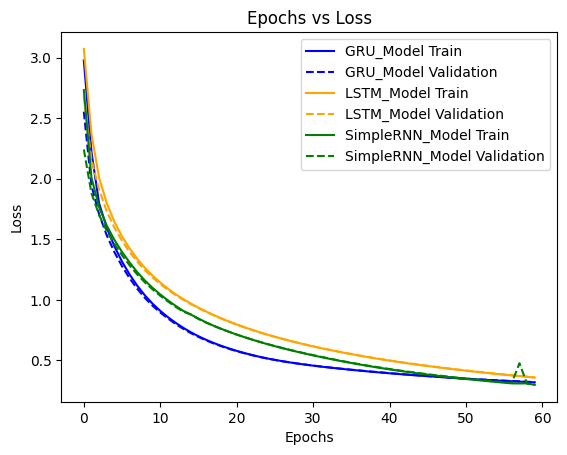

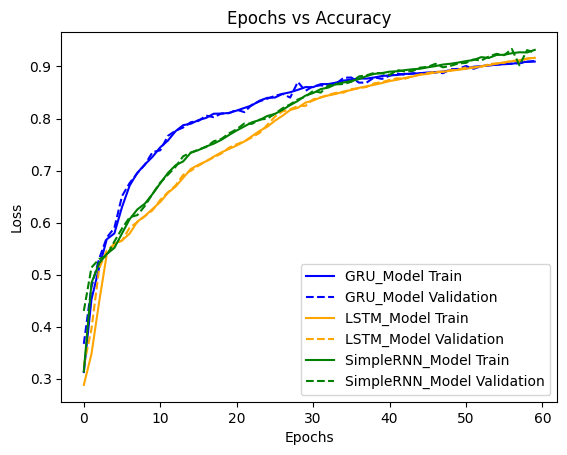

In [17]:
colors = ['blue', 'orange', 'green']

# Loss
for i, (model, history) in enumerate(models_history.items()):
    plt.plot(history.history['loss'], label=model + ' Train', color=colors[i])
    plt.plot(history.history['val_loss'], label=model + ' Validation', linestyle='dashed', color=colors[i])

# Set plot labels and title
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
for i, (model, history) in enumerate(models_history.items()):
    plt.plot(history.history['accuracy'], label=model + ' Train', color=colors[i])
    plt.plot(history.history['val_accuracy'], label=model + ' Validation', linestyle='dashed', color=colors[i])

plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### [Decoding encrypted messages](#decode)

In [18]:
encoded_line = encode_line("this is an encoded message that we will try to decipher")
encoded_line

'gvlo lo mq eqxucec heoomje gvmg pe plrr gwb gu cexlfvew'

In [19]:
def decode_message(model, encoded_message):
    encoded_message_int=[]
    for char in encoded_message:
        if char in tokenizer.word_index:
            encoded_message_int.append(tokenizer.word_index[char])
    padded_encoded_message = np.array(pad_sequences([encoded_message_int], L))
    padded_encoded_message = padded_encoded_message.reshape(-1,71,1)

    prediction = model.predict(padded_encoded_message, verbose=False)
    prediction = prediction.reshape(71,28)
    
    decoded_chars = []
    for array in prediction:
        decoded_chars.append(np.argmax(array))
    
    decoded_message = ""
    for element in decoded_chars:
        if element!=0: #exclude the 0's that come as a result of the padding
            decoded_message+=tokenizer.index_word[element]
    return decoded_message

In [20]:
for model in models:
    decoded_message = decode_message(model=model, encoded_message=encoded_line)
    print(f"{model.name}: {decoded_message}")

GRU_Model: this is an elroded message that we winn thy to deriprer
LSTM_Model: thas is an enroded message that we will thy to deriprer
SimpleRNN_Model: this is an encoded message that we winl thy to deripher
